In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors
from glob import glob

## Plot Config

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome",
    "taiwan" : "Taiwan Credit",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "M2FGB_grad" : "#8da0cb",
    "M2FGB_grad_tpr" : "#8da0cb",
    "M2FGB_grad_pr" : "#8da0cb",
    #"M2FGB" : "#66c2a5",
    "MinimaxPareto" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "FairGBMClassifier_eod" : "FairGBM (eod)",
    "M2FGB_grad" : "M²FGB",
    "M2FGB_grad_tpr" : "M²FGB (tpr)",
    "M2FGB_grad_pr" : "M²FGB (pr)",
    #"M2FGB" : "M²FGB opt.",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF"
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" not in key and "pr" not in key and "eod" not in key
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBM" in key or "eod" in key
]
handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBM" in key
]

## Functions

In [3]:
SEED = 0

In [4]:
def summary_experiment(dataset_name, model_name, path, fair_metric = "min_bal_acc", verbose = False):
    alpha_list = [i/20 for i in range(21)]
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    # For each fold
    for i in range(n_folds):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")
        results_test = pd.read_csv(path + f"test_fold_{i}.csv")

        if verbose and i == 0:
            print(f"{model_name}, {dataset_name}, {n_folds} n_folds, {results_val.model.unique().shape[0]} models")

        # adjust fairness metric to be better when closer to 1
        if fair_metric in ["eod", "spd"]:
            results_val[fair_metric] = 1 - np.abs(results_val[fair_metric])
            results_test[fair_metric] = 1 - np.abs(results_test[fair_metric])
        results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

        for alpha in alpha_list:
            results_val["score"] = alpha * results_val["bal_acc"] + (1 - alpha) * (results_val[fair_metric])
            results_test["score"] = alpha * results_test["bal_acc"] + (1 - alpha) * (results_test[fair_metric])

            best_model_val = results_val.sort_values("score", ascending=False).head(1).model.values[0]

            best_model_test = results_test[results_test.model == best_model_val]
            
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model_test.bal_acc.values[0],
                fair_metric : best_model_test[fair_metric].values[0],
                "dataset" : dataset_name,
                "model" : model_name,
                "time" : best_model_test.duration.values[0],
                "score" : best_model_test.score.values[0]
            })

    #results = pd.DataFrame(results).groupby(["dataset", "model", "alpha"]).mean().reset_index()
    return pd.DataFrame(results)

## Bal Acc

### old plot

M2FGB_grad, german, 10 n_folds, 500 models
FairGBMClassifier, german, 10 n_folds, 500 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 500 models
MinimaxPareto, german, 10 n_folds, 100 models
M2FGB_grad, german, 10 n_folds, 500 models
FairGBMClassifier, german, 10 n_folds, 500 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 500 models
MinimaxPareto, german, 10 n_folds, 100 models
M2FGB_grad, german, 10 n_folds, 500 models
FairGBMClassifier, german, 10 n_folds, 500 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 500 models
MinimaxPareto, german, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 500 models
FairGBMClassifier, compas, 10 n_folds, 500 models
MinMaxFair, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 500 models
MinimaxPareto, compas, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 500 models
FairGBMClassifier, compas, 10 n_folds, 50

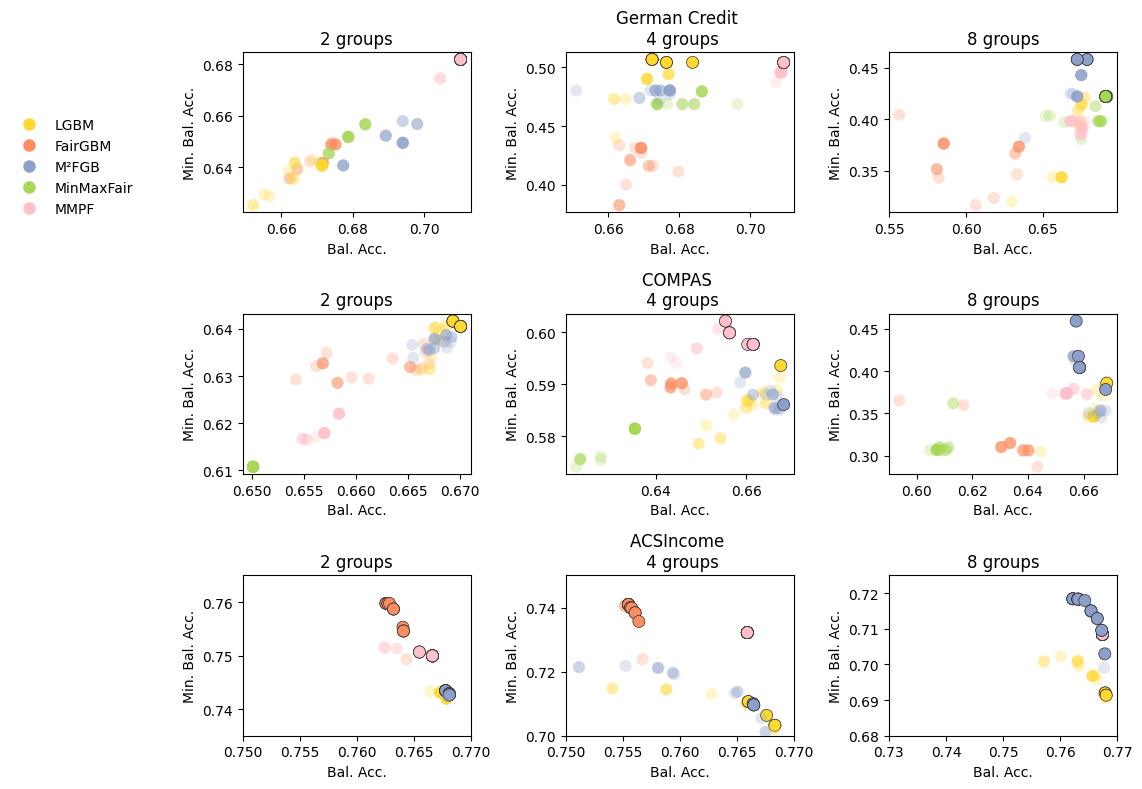

In [238]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 8))

methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
fair_metric = "min_bal_acc"
max_models = 100
for jj, dataset_name in enumerate(["german", "compas",  "acsincome"]):
    for ii, n_groups in enumerate([2, 4, 8]):
        results = []
        for model_name in methods:
            path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))
            except:
                pass

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue
            
            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],
                #marker = "D" if model_name != "M2FGB_grad" else "o"
            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal. Acc.")
        axs[jj, ii].set_ylabel("Min. Bal. Acc.")
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, -0.1), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        

axs[2, 0].set_xlim([0.75, 0.77])
axs[2, 0].set_ylim([0.735, 0.765])

axs[2, 1].set_xlim([0.75, 0.77])
axs[2, 1].set_ylim([0.7, 0.75])

axs[2, 2].set_xlim([0.73, 0.77])
axs[2, 2].set_ylim([0.68, 0.725])


plt.tight_layout()
plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

### new plots

M2FGB_grad, german, 10 n_folds, 100 models
FairGBMClassifier, german, 10 n_folds, 100 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad, german, 10 n_folds, 100 models
FairGBMClassifier, german, 10 n_folds, 100 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 100 models
FairGBMClassifier, compas, 10 n_folds, 100 models
MinMaxFair, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 100 models
FairGBMClassifier, compas, 10 n_folds, 100 models
MinMaxFair, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad, taiwan, 10 n_folds, 100 models
FairGBMClassifier, taiwan, 10 n_folds, 100 models
MinMaxFair, taiwan, 10 n_folds, 25 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad, taiwan, 10 n_folds, 25 models
FairGBMClassifier, taiwan, 10 n_folds, 25 mo

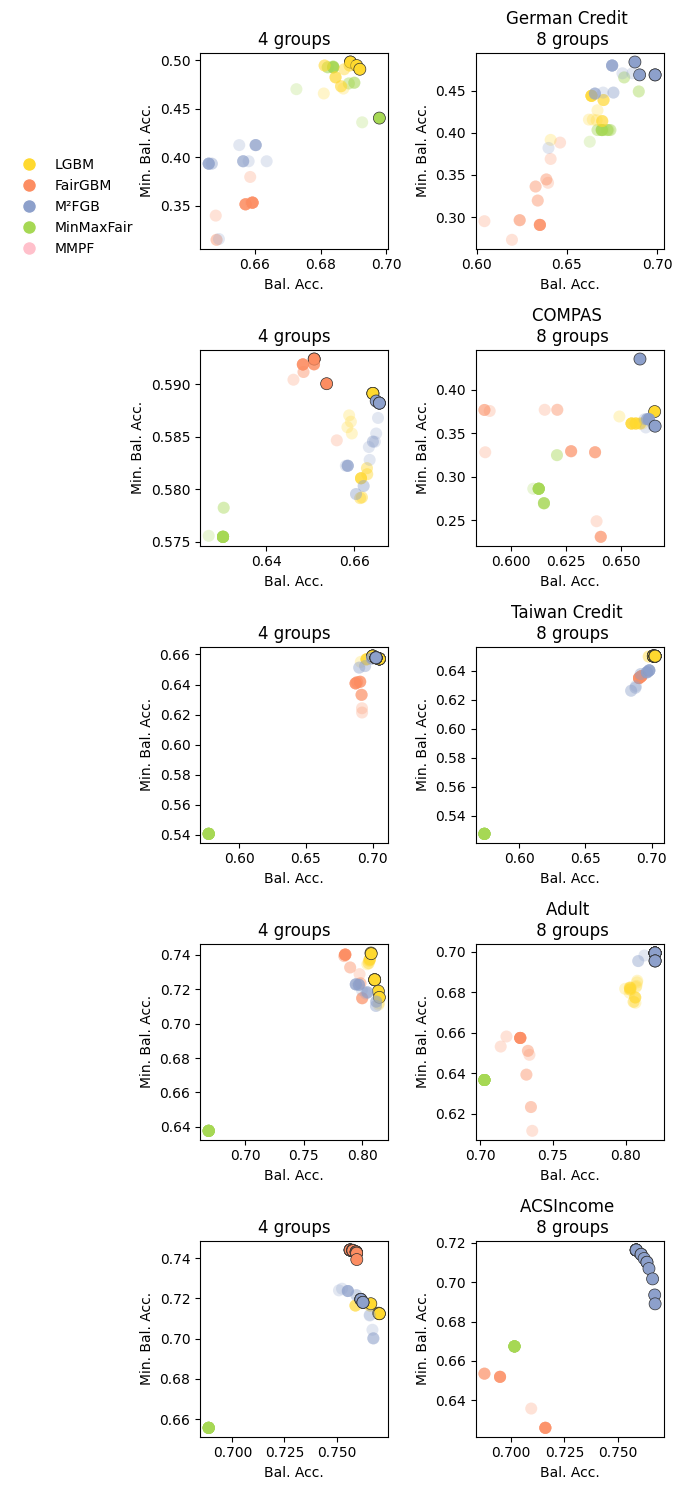

In [13]:
datasets = ["german", "compas", "taiwan", "adult", "acsincome"]
n_groups_list = [4, 8]
fig, axs = plt.subplots(nrows = len(datasets), ncols = len(n_groups_list), figsize = (4 * len(n_groups_list), 3 * len(datasets)))

methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    #"MinimaxPareto"
]
fair_metric = "min_bal_acc"
max_models = 100
for jj, dataset_name in enumerate(datasets):
    for ii, n_groups in enumerate(n_groups_list):
        results = []
        for model_name in methods:
            path = f"../results_aaai/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))
            except:
                pass

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue
            
            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],
                #marker = "D" if model_name != "M2FGB_grad" else "o"
            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal. Acc.")
        axs[jj, ii].set_ylabel("Min. Bal. Acc.")
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, -0.1), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        

# axs[2, 0].set_xlim([0.75, 0.77])
# axs[2, 0].set_ylim([0.735, 0.765])

# axs[2, 1].set_xlim([0.75, 0.77])
# axs[2, 1].set_ylim([0.7, 0.75])

# axs[2, 2].set_xlim([0.73, 0.77])
# axs[2, 2].set_ylim([0.68, 0.725])


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

M2FGB_grad, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad, taiwan, 10 n_folds, 100 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad, taiwan, 10 n_folds, 100 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad, adult, 10 n_folds, 100 models
LGBMClassifier, adult, 10 n_folds, 100 models
M2FGB_grad, adult, 10 n_folds, 100 models
LGBMClassifier, adult, 10 n_folds, 100 models


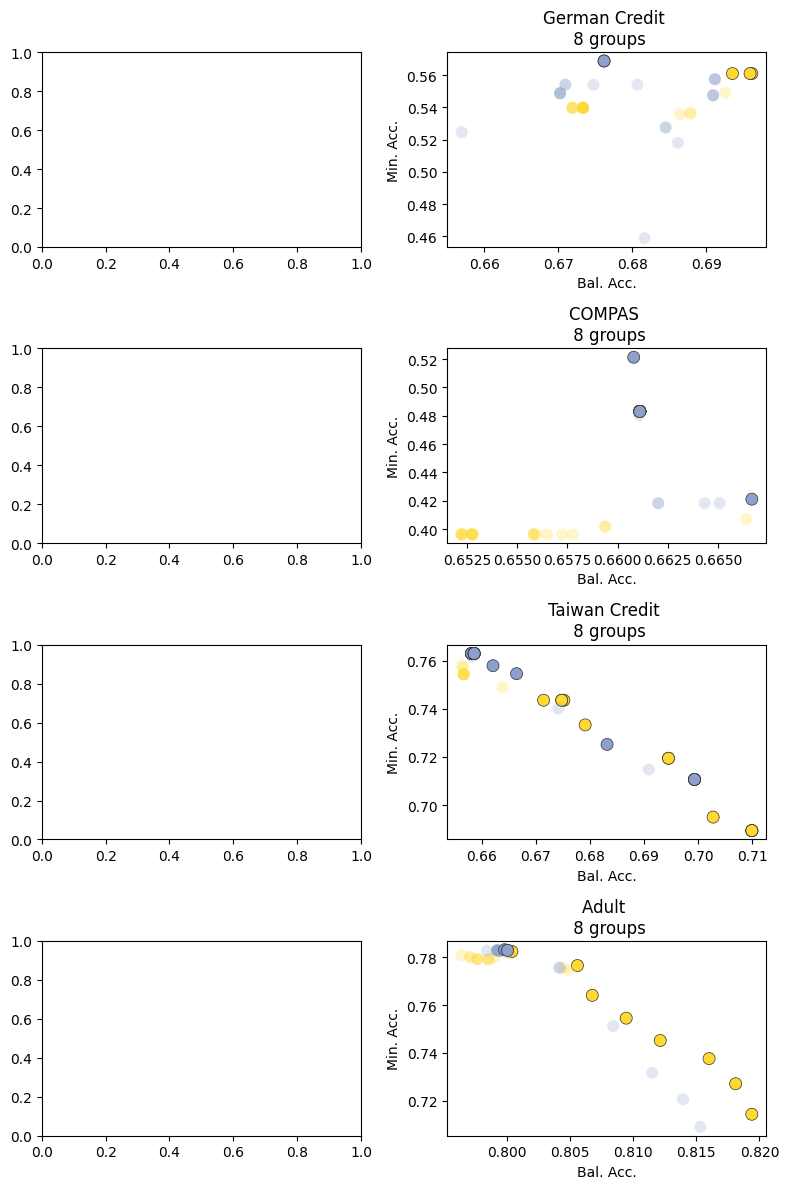

In [83]:
datasets = ["german", "compas", "taiwan", "adult"]
n_groups_list = [4, 8]
fig, axs = plt.subplots(nrows = len(datasets), ncols = len(n_groups_list), figsize = (4 * len(n_groups_list), 3 * len(datasets)))

methods = [
    "M2FGB_grad",
    #"FairGBMClassifier",
    #"MinMaxFair",
    "LGBMClassifier",
    #"MinimaxPareto"
]
fair_metric = "min_acc"
max_models = 100
for jj, dataset_name in enumerate(datasets):
    for ii, n_groups in enumerate(n_groups_list):
        results = []
        for model_name in methods:
            path = f"../results_aaai/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, verbose = True))
            except:
                pass
        
        if len(results) == 0:
            continue
        results = pd.concat(results)
        results_std = results.groupby(["dataset", "model", "alpha"]).std().reset_index()
        results = results.groupby(["dataset", "model", "alpha"]).mean().reset_index()

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue
            
            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],
                #marker = "D" if model_name != "M2FGB_grad" else "o"
            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal. Acc.")
        axs[jj, ii].set_ylabel("Min. Acc.")
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, -0.1), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        

# axs[2, 0].set_xlim([0.75, 0.77])
# axs[2, 0].set_ylim([0.735, 0.765])

# axs[2, 1].set_xlim([0.75, 0.77])
# axs[2, 1].set_ylim([0.7, 0.75])

# axs[2, 2].set_xlim([0.73, 0.77])
# axs[2, 2].set_ylim([0.68, 0.725])


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

M2FGB_grad, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad, taiwan, 10 n_folds, 100 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad, adult, 10 n_folds, 100 models
LGBMClassifier, adult, 10 n_folds, 100 models


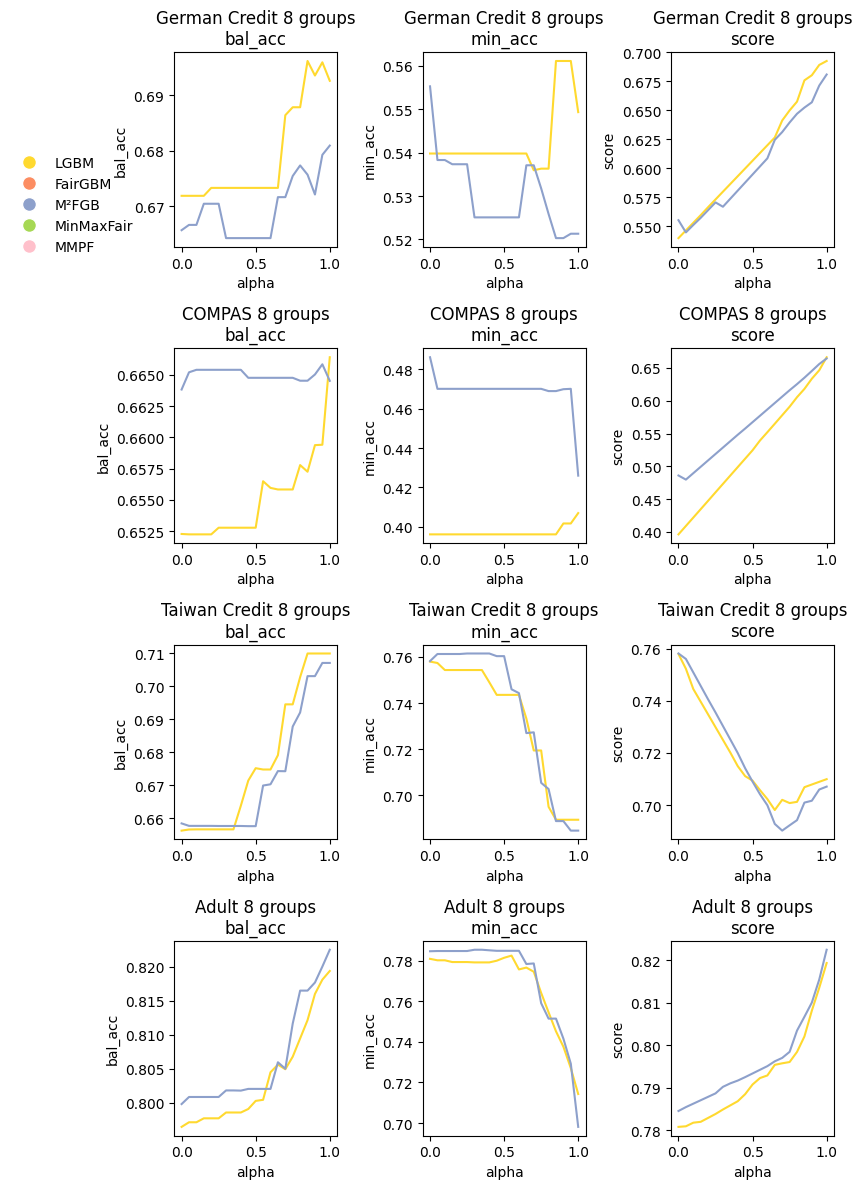

In [92]:
datasets = ["german", "compas", "taiwan", "adult"]#, "acsincome"]
n_groups_list = [8]
fig, axs = plt.subplots(nrows = len(datasets), ncols = 3, figsize = (9, 3 * len(datasets)))

methods = [
    "M2FGB_grad",
    #"FairGBMClassifier",
    #"MinMaxFair",
    "LGBMClassifier",
    #"MinimaxPareto"
]
fair_metric = "min_acc"
max_models = 100
n_groups = 8
for jj, dataset_name in enumerate(datasets):
    results = []
    for model_name in methods:
        path = f"../results_aaai/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        try:
            results.append(summary_experiment(dataset_name, model_name, path, fair_metric, verbose = True))
        except:
            pass
    
    if len(results) == 0:
        continue
    results = pd.concat(results)
    results_std = results.groupby(["dataset", "model", "alpha"]).std().reset_index()
    results = results.groupby(["dataset", "model", "alpha"]).mean().reset_index()

    for model_name in methods:
        results_m = results[results.model == model_name]
        results_m_std = results_std[results_std.model == model_name]
        if results_m.shape[0] == 0:
            continue

        for ii, metric_name in enumerate(["bal_acc", fair_metric, "score"]):
        
            axs[jj, ii].plot(
                results_m.alpha,
                results_m[metric_name],
                c = methods_color[model_name],
                label = model_name,
                zorder = 10 if model_name != "M2FGB_grad" else 100,
            )
        
            axs[jj, ii].set_xlabel("alpha")
            axs[jj, ii].set_ylabel(metric_name)
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} {n_groups} groups\n{metric_name}")

            # axs[jj, ii].fill_between(
            #     results_m.alpha,
            #     results_m[metric_name] - results_m_std[metric_name],
            #     results_m[metric_name] + results_m_std[metric_name],
            #     color = methods_color[model_name],
            #     alpha = 0.25,
            #     zorder = 0
            # )
    
    
axs[0, 0].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, -0.1), frameon=False)

plt.tight_layout()
plt.show()

## SPD

LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_pr, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_pr, german, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_pr, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_pr, compas, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_pr, acsincome, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_pr, acsincome, 10 n_folds, 100 models


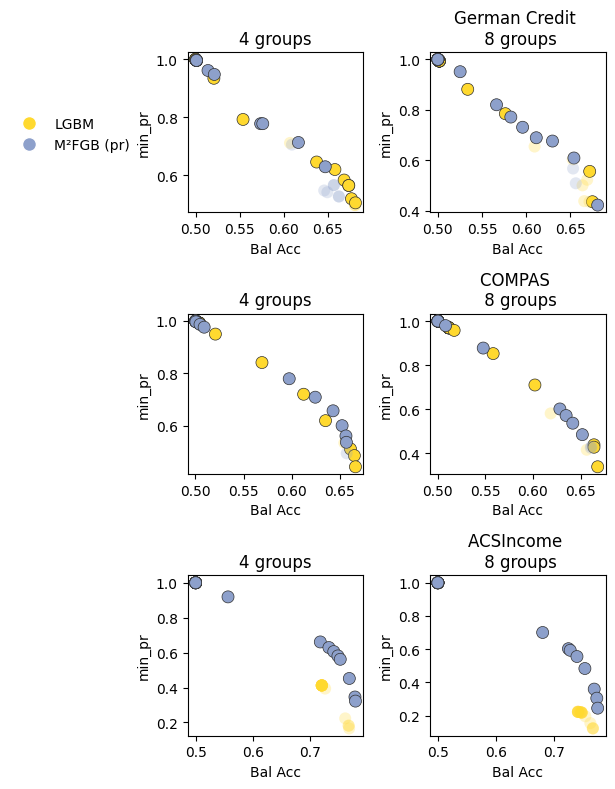

In [189]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (7, 8))

methods = [
    "LGBMClassifier",
    "M2FGB_grad_pr",
]
fair_metric = "min_pr"
max_models = 100
for jj, dataset_name in enumerate(["german", "compas",  "acsincome"]):
    for ii, n_groups in enumerate([4, 8]):
        results = []
        for model_name in methods:
            path = f"../results/experiment_{n_groups}_pr/{dataset_name}/{model_name}/"
            results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]

            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],

            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal Acc")
        axs[jj, ii].set_ylabel(fair_metric)
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles_pr, loc="lower left", bbox_to_anchor=(-1.05, 0.3), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

## TPR

LGBMClassifier, german, 10 n_folds, 100 models


M2FGB_grad_tpr, german, 10 n_folds, 100 models
MinMaxFair_tpr, german, 10 n_folds, 100 models
FairGBMClassifier_eod, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_tpr, german, 10 n_folds, 100 models
MinMaxFair_tpr, german, 10 n_folds, 100 models
FairGBMClassifier_eod, german, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
MinMaxFair_tpr, compas, 10 n_folds, 100 models
FairGBMClassifier_eod, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
MinMaxFair_tpr, compas, 10 n_folds, 100 models
FairGBMClassifier_eod, compas, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_tpr, acsincome, 10 n_folds, 100 models
MinMaxFair_tpr, acsincome, 10 n_folds, 25 models
FairGBMClassifier_eod, acsincome, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_

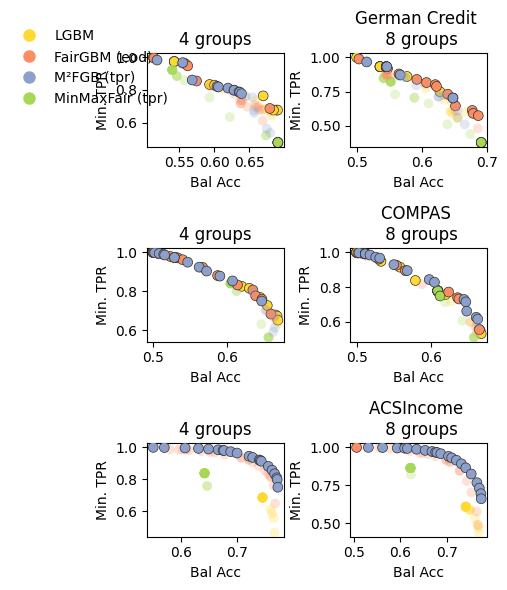

In [239]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (6, 6))

methods = [
    "LGBMClassifier",
    "M2FGB_grad_tpr",
    "MinMaxFair_tpr",
    "FairGBMClassifier_eod",
]
fair_metric = "min_tpr"
max_models = 100
for jj, dataset_name in enumerate(["german", "compas",  "acsincome"]):
    for ii, n_groups in enumerate([4, 8]):
        results = []
        for model_name in methods:
            path = f"../results/experiment_{n_groups}_tpr/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))
            except:
                pass

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue

            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 50,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad_tpr" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],
                #marker = "D" if model_name != "M2FGB_grad_tpr" else "o"
            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal Acc")
        axs[jj, ii].set_ylabel("Min. TPR")
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles_tpr, loc="lower left", bbox_to_anchor=(-1.05, 0.3), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        


plt.tight_layout()
plt.savefig("../figs/results_datasets_tpr.pdf", dpi = 300)
plt.show()

LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_tpr, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_tpr, german, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad_tpr, taiwan, 10 n_folds, 100 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad_tpr, taiwan, 10 n_folds, 100 models
LGBMClassifier, adult, 10 n_folds, 100 models
M2FGB_grad_tpr, adult, 10 n_folds, 100 models
LGBMClassifier, adult, 10 n_folds, 100 models
M2FGB_grad_tpr, adult, 10 n_folds, 100 models


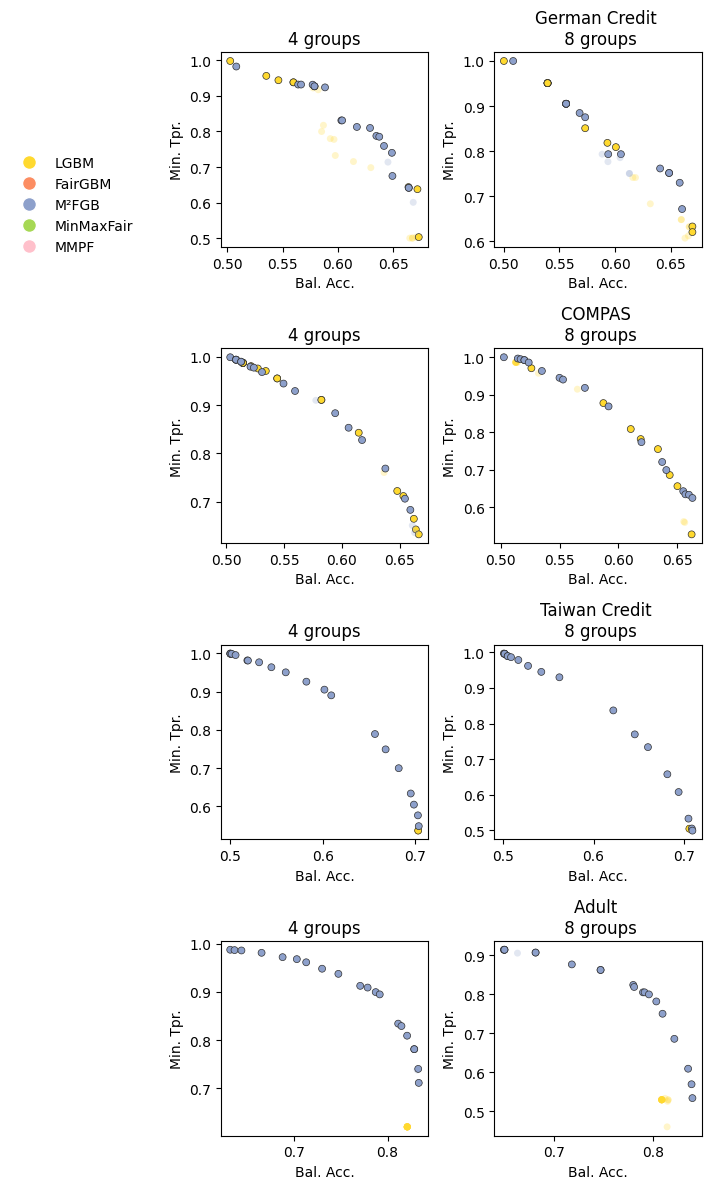

In [62]:
datasets = ["german", "compas", "taiwan", "adult"]#, "acsincome"]
n_groups_list = [4, 8]
fig, axs = plt.subplots(nrows = len(datasets), ncols = len(n_groups_list), figsize = (4 * len(n_groups_list), 3 * len(datasets)))

methods = [
    "LGBMClassifier",
    "M2FGB_grad_tpr",
    #"FairGBMClassifier",
    #"MinMaxFair",
    
    #"MinimaxPareto"
]
fair_metric = "min_tpr"
max_models = 100
for jj, dataset_name in enumerate(datasets):
    for ii, n_groups in enumerate(n_groups_list):
        results = []
        for model_name in methods:
            path = f"../results_aaai/experiment_{n_groups}_tpr/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, verbose = True))
            except:
                pass

        if len(results) == 0:
            continue

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue
            
            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 25,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],
                #marker = "D" if model_name != "M2FGB_grad" else "o"
            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal. Acc.")
        axs[jj, ii].set_ylabel("Min. Tpr.")
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, -0.1), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        

# axs[2, 0].set_xlim([0.75, 0.77])
# axs[2, 0].set_ylim([0.735, 0.765])

# axs[2, 1].set_xlim([0.75, 0.77])
# axs[2, 1].set_ylim([0.7, 0.75])

# axs[2, 2].set_xlim([0.73, 0.77])
# axs[2, 2].set_ylim([0.68, 0.725])


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

M2FGB_grad_tpr, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, taiwan, 10 n_folds, 100 models
LGBMClassifier, taiwan, 10 n_folds, 100 models
M2FGB_grad_tpr, adult, 10 n_folds, 100 models
LGBMClassifier, adult, 10 n_folds, 100 models


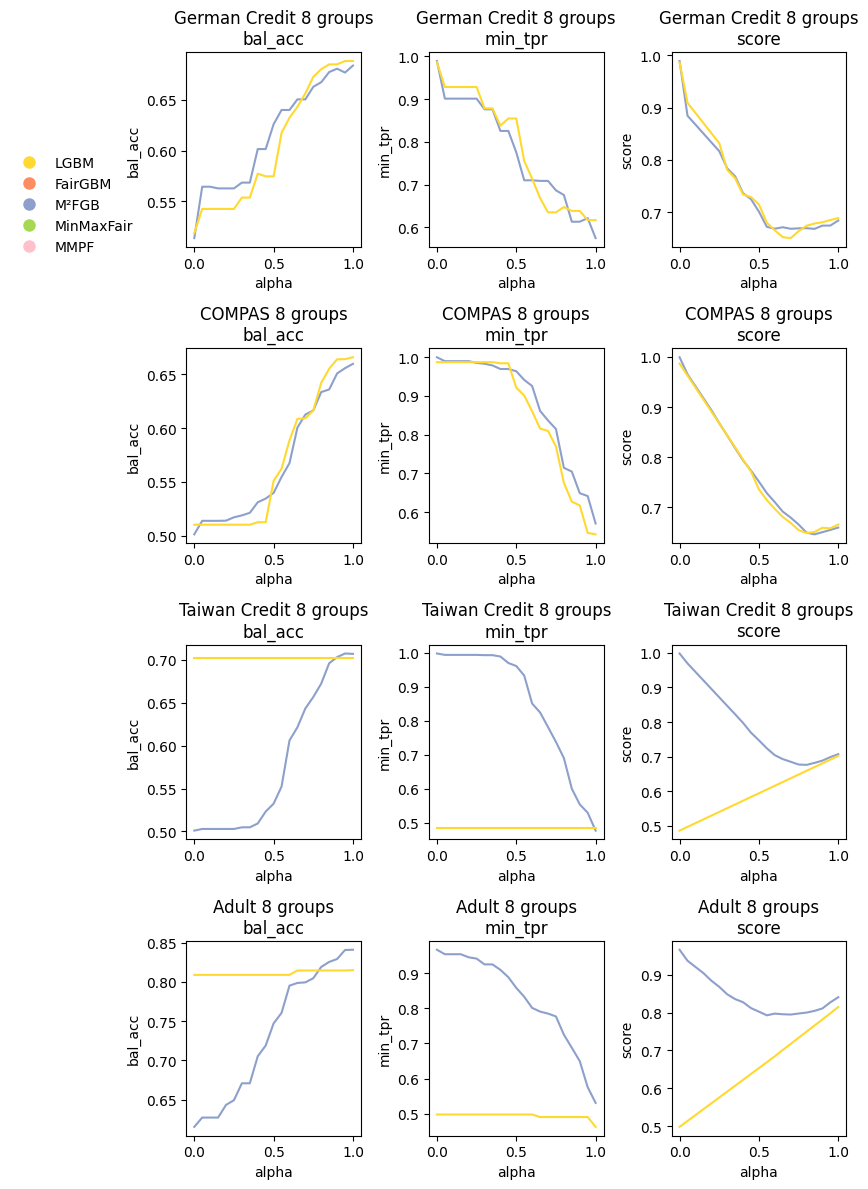

In [63]:
datasets = ["german", "compas", "taiwan", "adult"]#, "acsincome"]
n_groups_list = [8]
fig, axs = plt.subplots(nrows = len(datasets), ncols = 3, figsize = (9, 3 * len(datasets)))

methods = [
    "M2FGB_grad_tpr",
    #"FairGBMClassifier",
    #"MinMaxFair",
    "LGBMClassifier",
    #"MinimaxPareto"
]
fair_metric = "min_tpr"
max_models = 100
n_groups = 8
for jj, dataset_name in enumerate(datasets):
    results = []
    for model_name in methods:
        path = f"../results_aaai/experiment_{n_groups}_tpr/{dataset_name}/{model_name}/"
        try:
            results.append(summary_experiment(dataset_name, model_name, path, fair_metric, verbose = True))
        except:
            pass
    
    if len(results) == 0:
        continue
    results = pd.concat(results)
    results_std = results.groupby(["dataset", "model", "alpha"]).std().reset_index()
    results = results.groupby(["dataset", "model", "alpha"]).mean().reset_index()

    for model_name in methods:
        results_m = results[results.model == model_name]
        results_m_std = results_std[results_std.model == model_name]
        if results_m.shape[0] == 0:
            continue

        for ii, metric_name in enumerate(["bal_acc", fair_metric, "score"]):
        
            axs[jj, ii].plot(
                results_m.alpha,
                results_m[metric_name],
                c = methods_color[model_name],
                label = model_name,
                zorder = 10 if model_name != "M2FGB_grad" else 100,
            )
        
            axs[jj, ii].set_xlabel("alpha")
            axs[jj, ii].set_ylabel(metric_name)
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} {n_groups} groups\n{metric_name}")

            # axs[jj, ii].fill_between(
            #     results_m.alpha,
            #     results_m[metric_name] - results_m_std[metric_name],
            #     results_m[metric_name] + results_m_std[metric_name],
            #     color = methods_color[model_name],
            #     alpha = 0.25,
            #     zorder = 0
            # )
    
    
axs[0, 0].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, -0.1), frameon=False)

plt.tight_layout()
plt.show()

## Computing Time

In [16]:
def summary_time(dataset_name, model_name, path, max_models = None):
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    # For each fold
    for i in range(n_folds):
        trials = pd.read_csv(path + f"trials_fold_{i}.csv")
        trials["duration"] = pd.to_timedelta(trials["duration"]).dt.total_seconds()

        # sample models if there is a limit of max_models
        if i == 0: 
            model_list = np.arange(trials.shape[0])
            if max_models is not None and len(model_list) > max_models:
                np.random.seed(SEED)
                model_list = np.random.choice(model_list, size = max_models, replace = False)

        if max_models is not None:
            trials = trials.iloc[model_list]
        results.append(trials)

    results = pd.concat(results)[["duration"]]
    results = "$" + results.mean().round(2).astype(str) + " (\pm " + results.std().round(2).astype(str) + ")$"
    results["model"] = model_name
    results["dataset"] = dataset_name
    results = pd.DataFrame(results).T
    return results

In [159]:
results = []

methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
n_groups = 8
error = 0
for dataset_name in ["german", "compas", "acsincome"]:
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        try:
            results.append(summary_time(dataset_name, model_name, path, 100))
        except:
            error += 1
results = pd.concat(results)

In [19]:
results = []

methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    #"LGBMClassifier",
    #"MinimaxPareto"
]
n_groups = 8
error = 0
for dataset_name in ["german", "compas", "acsincome"]:
    for model_name in methods:
        path = f"../results_aaai/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        try:
            results.append(summary_time(dataset_name, model_name, path, 100))
        except:
            error += 1
results = pd.concat(results)

In [20]:
results.sort_values("model")

,duration,model,dataset
0,$0.31 (\pm 0.29)$,FairGBMClassifier,german
0,$0.43 (\pm 0.35)$,FairGBMClassifier,compas
0,$28.33 (\pm 22.57)$,FairGBMClassifier,acsincome
0,$0.97 (\pm 0.99)$,M2FGB_grad,german
0,$1.16 (\pm 1.15)$,M2FGB_grad,compas
0,$89.42 (\pm 85.83)$,M2FGB_grad,acsincome
0,$21.81 (\pm 22.24)$,MinMaxFair,german
0,$47.36 (\pm 47.06)$,MinMaxFair,compas
0,$625.62 (\pm 227.13)$,MinMaxFair,acsincome


In [160]:
results.sort_values("model")

,duration,model,dataset
0,$0.34 (\pm 0.36)$,FairGBMClassifier,german
0,$0.43 (\pm 0.37)$,FairGBMClassifier,compas
0,$50.58 (\pm 44.47)$,FairGBMClassifier,acsincome
0,$0.28 (\pm 0.42)$,LGBMClassifier,german
0,$0.4 (\pm 0.55)$,LGBMClassifier,compas
0,$20.12 (\pm 20.51)$,LGBMClassifier,acsincome
0,$4.68 (\pm 4.61)$,M2FGB_grad,german
0,$6.44 (\pm 6.53)$,M2FGB_grad,compas
0,$158.91 (\pm 160.58)$,M2FGB_grad,acsincome
0,$25.49 (\pm 25.7)$,MinMaxFair,german


## $\lambda$ parameter

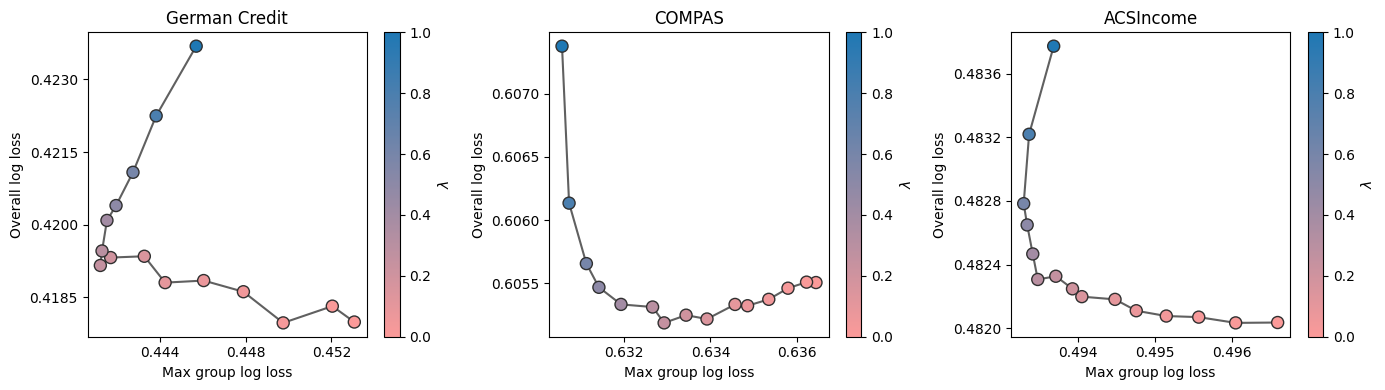

In [8]:
norm=matplotlib.colors.Normalize(0, 1)
#norm=matplotlib.colors.Normalize(0,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows =1, ncols = 3, figsize = (14, 4))

for i, dataset in enumerate(["german", "compas", "acsincome"]):
    results = pd.read_csv(f"../results/experiment_fair_weight/{dataset}.csv")
    results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()
    #results = results[results.fair_weight > 0]

    
    cm = axs[i].scatter(
        results.max_group_score,
        results.overall_score,
        c = results.fair_weight,
        cmap = cmap,
        norm = norm,
        zorder = 100,
        s = 75,
        ec = "#303030",
    )

    axs[i].plot(
        results.max_group_score,
        results.overall_score,
        c = "#606060",
    )

    axs[i].set_xlabel("Max group log loss")
    axs[i].set_ylabel("Overall log loss")

    axs[i].set_title(dataset_names[dataset])

    # make x and y axis only have 4 ticks each
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[i], label="$\lambda$")

plt.tight_layout()

plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()




In [25]:
dataset = "compas"
perf_metric = "acc"
fair_metric = "min_acc"
n_groups = 8
experiment_folder = f"experiment_{n_groups}g_min_acc"
alpha_list = [i/100 for i in range(101)]
df_results = []
for model in ["M2FGB_grad", "LGBMClassifier", "FairGBMClassifier"]:
    try:
        for fold in range(10):
            results_val = pd.read_csv(f"../results_aaai/{experiment_folder}/{dataset}/{model}/validation_fold_{fold}.csv")
            results_test = pd.read_csv(f"../results_aaai/{experiment_folder}/{dataset}/{model}/test_fold_{fold}.csv")
            results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
            results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()
            
            for alpha in alpha_list:

                for _ in range(100):
                    score = alpha * results_val[fair_metric] + (1 - alpha) * results_val[perf_metric]
                    # sample some score
                    score = score.sample(frac = 0.2)
                    best_model = results_test.iloc[score.idxmax()]


                    df_results.append({
                        "dataset" : dataset,
                        "model" : model,
                        "fold" : fold,
                        "alpha" : alpha,
                        perf_metric : best_model[perf_metric],
                        fair_metric : best_model[fair_metric],
                        "duration" : best_model.duration,
                    })
    except:
        continue


df_results = pd.DataFrame(df_results)
df_results_std = df_results.groupby(["dataset", "model", "alpha"]).std().reset_index()
df_results = df_results.groupby(["dataset", "model", "alpha"]).mean().reset_index()

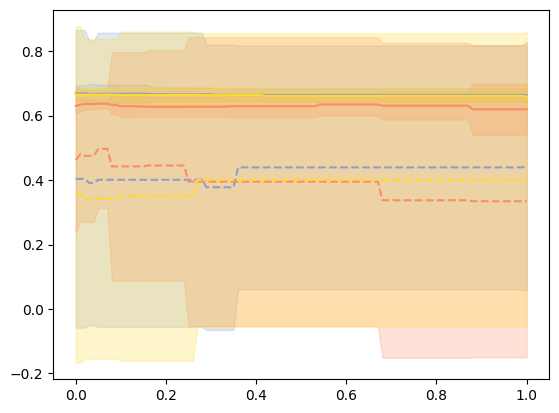

In [18]:
for model in ["M2FGB_grad", "FairGBMClassifier", "LGBMClassifier"]:
    df_results_filter = df_results[df_results.model == model]
    df_results_filter_std = df_results_std[df_results_std.model == model]

    plt.plot(
        df_results_filter.alpha,
        df_results_filter[perf_metric],
        c = methods_color[model],
    )

    plt.fill_between(
        df_results_filter.alpha,
        # draw 95% confidence interval
        df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        color = methods_color[model],
        alpha = 0.25,
    )

    plt.plot(
        df_results_filter.alpha,
        df_results_filter[fair_metric],
        linestyle = "--",
        c = methods_color[model],
    )

    plt.fill_between(
        df_results_filter.alpha,
        # draw 95% confidence interval
        df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        color = methods_color[model],
        alpha = 0.25,
    )

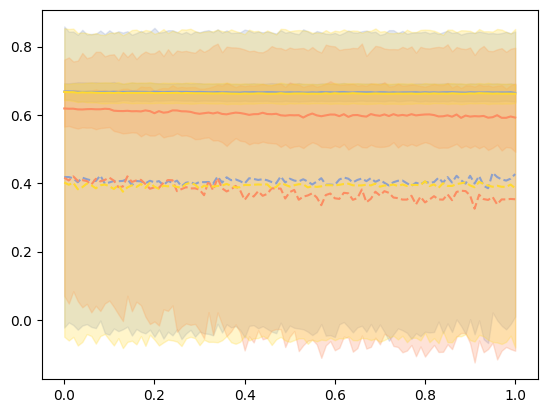

In [20]:
for model in ["M2FGB_grad", "FairGBMClassifier", "LGBMClassifier"]:
    df_results_filter = df_results[df_results.model == model]
    df_results_filter_std = df_results_std[df_results_std.model == model]

    plt.plot(
        df_results_filter.alpha,
        df_results_filter[perf_metric],
        c = methods_color[model],
    )

    plt.fill_between(
        df_results_filter.alpha,
        # draw 95% confidence interval
        df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        color = methods_color[model],
        alpha = 0.25,
    )

    plt.plot(
        df_results_filter.alpha,
        df_results_filter[fair_metric],
        linestyle = "--",
        c = methods_color[model],
    )

    plt.fill_between(
        df_results_filter.alpha,
        # draw 95% confidence interval
        df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        color = methods_color[model],
        alpha = 0.25,
    )

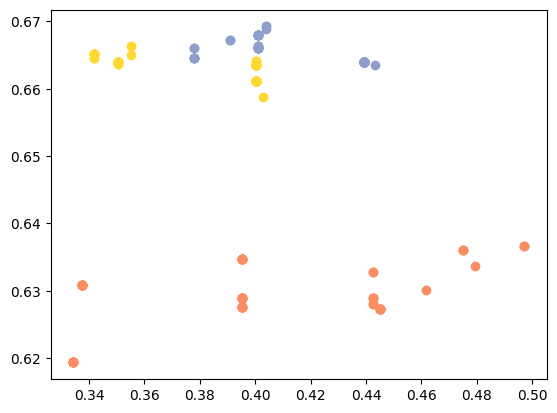

In [13]:
for model in ["M2FGB_grad", "FairGBMClassifier", "LGBMClassifier"]:
    df_results_filter = df_results[df_results.model == model]

    plt.scatter(
        df_results_filter[fair_metric],
        df_results_filter[perf_metric],
        c = methods_color[model],
    )